In [1]:
from scipy.stats import norm
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from bucket_data import get_borough,bucket_by_time
from rush_off_bound import rush_off_bound
from distribution_check import poisson_check,nb_check,weibull_check
from distance_metric import haversine_distance

In [2]:
DATA_DIR = '202401-citibike-tripdata_2.csv'
DATA_DIR_2  = '202401-citibike-tripdata_1.csv'
data = pl.read_csv(DATA_DIR,ignore_errors=True)
data2 = pl.read_csv(DATA_DIR_2,ignore_errors=True)
data = data.vstack(data2)
print(data.sort('started_at'))

shape: (1_888_085, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ride_id   ┆ rideable_ ┆ started_a ┆ ended_at  ┆ … ┆ start_lng ┆ end_lat   ┆ end_lng   ┆ member_c │
│ ---       ┆ type      ┆ t         ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ asual    │
│ str       ┆ ---       ┆ ---       ┆ str       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆ str       ┆ str       ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 5594D8DDA ┆ classic_b ┆ 2023-12-3 ┆ 2024-01-0 ┆ … ┆ -73.98765 ┆ null      ┆ null      ┆ casual   │
│ 68F5BB9   ┆ ike       ┆ 1 02:36:5 ┆ 1 03:36:4 ┆   ┆ 4         ┆           ┆           ┆          │
│           ┆           ┆ 5.648     ┆ 8.341     ┆   ┆           ┆           ┆           ┆          │
│ 36D094894 ┆ classic_b ┆ 2023-12-3 ┆ 2024-01-0 ┆ … ┆ -73.98770 ┆ nu

In [3]:
data = data.with_columns(
    pl.col("started_at").str.to_datetime(strict=False),
    pl.col("ended_at").str.to_datetime(strict=False)
)
data = data.with_columns(
    pl.col("started_at").dt.date().alias("start_date"),
    pl.col("started_at").dt.time().alias("start_time"),
    pl.col("ended_at").dt.date().alias("end_date"),
    pl.col("ended_at").dt.time().alias("end_time"),
)
data = data.with_columns(
    (pl.col("ended_at")- pl.col("started_at")).alias("trip_time")
)
data = data.with_columns(
    pl.struct(['start_lat', 'start_lng'])
    .map_elements(
        lambda x: get_borough(x['start_lat'], x['start_lng']),
        return_dtype=pl.Utf8
    )
    .alias('start_borough')
)
data = data.with_columns(
    pl.struct(['end_lat', 'end_lng'])
    .map_elements(
        lambda x: get_borough(x['end_lat'], x['end_lng']),
        return_dtype=pl.Utf8
    )
    .alias('end_borough')
)


counts = data['end_borough'].value_counts()
print(counts)
print(data.head(0))


shape: (4, 2)
┌─────────────┬─────────┐
│ end_borough ┆ count   │
│ ---         ┆ ---     │
│ str         ┆ u32     │
╞═════════════╪═════════╡
│ Brooklyn    ┆ 323024  │
│ Manhattan   ┆ 1500095 │
│ Unknown     ┆ 5578    │
│ Bronx       ┆ 59388   │
└─────────────┴─────────┘
shape: (0, 20)
┌─────────┬────────────┬────────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ ride_id ┆ rideable_t ┆ started_at ┆ ended_at  ┆ … ┆ end_time ┆ trip_time ┆ start_bor ┆ end_borou │
│ ---     ┆ ype        ┆ ---        ┆ ---       ┆   ┆ ---      ┆ ---       ┆ ough      ┆ gh        │
│ str     ┆ ---        ┆ datetime[μ ┆ datetime[ ┆   ┆ time     ┆ duration[ ┆ ---       ┆ ---       │
│         ┆ str        ┆ s]         ┆ μs]       ┆   ┆          ┆ μs]       ┆ str       ┆ str       │
╞═════════╪════════════╪════════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
└─────────┴────────────┴────────────┴───────────┴───┴──────────┴───────────┴───────────┴───────────┘


In [4]:
weekday_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
weekday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
peak_hours = [7,8,9,10,16,17,18,19]

data = data.with_columns([
    # Distance calculation
    pl.struct(['start_lat','start_lng','end_lat', 'end_lng'])
    .map_elements(
        lambda x: haversine_distance(x['start_lat'], x['start_lng'], x['end_lat'], x['end_lng']),
        return_dtype=pl.Float64
    )
    .alias('distance'),
    pl.col('started_at').dt.hour().alias('hour'),
    pl.col('started_at').dt.strftime('%A').alias('day'),

])
data= data.with_columns([
    pl.col('hour').is_in(peak_hours).alias('peak_hours'),
    pl.col('day').is_in(weekday).alias('weekday'),
])


print(data)

shape: (1_888_085, 25)
┌─────────────┬────────────┬────────────┬────────────┬───┬──────┬───────────┬────────────┬─────────┐
│ ride_id     ┆ rideable_t ┆ started_at ┆ ended_at   ┆ … ┆ hour ┆ day       ┆ peak_hours ┆ weekday │
│ ---         ┆ ype        ┆ ---        ┆ ---        ┆   ┆ ---  ┆ ---       ┆ ---        ┆ ---     │
│ str         ┆ ---        ┆ datetime[μ ┆ datetime[μ ┆   ┆ i8   ┆ str       ┆ bool       ┆ bool    │
│             ┆ str        ┆ s]         ┆ s]         ┆   ┆      ┆           ┆            ┆         │
╞═════════════╪════════════╪════════════╪════════════╪═══╪══════╪═══════════╪════════════╪═════════╡
│ 62EF1AC5BE5 ┆ classic_bi ┆ 2024-01-24 ┆ 2024-01-24 ┆ … ┆ 9    ┆ Wednesday ┆ true       ┆ true    │
│ 98131       ┆ ke         ┆ 09:03:33.5 ┆ 09:06:53.5 ┆   ┆      ┆           ┆            ┆         │
│             ┆            ┆ 33         ┆ 35         ┆   ┆      ┆           ┆            ┆         │
│ 8464E543DAB ┆ classic_bi ┆ 2024-01-30 ┆ 2024-01-30 ┆ … ┆ 8    ┆ Tu

In [5]:
subset_peak_weekday = data.filter(
    (pl.col('peak_hours') == True) & (pl.col('weekday') == True) &(pl.col('distance')>0)
).select(['trip_time', 'distance', 'rideable_type'])

# Subset 2: Peak hours + Weekend
subset_peak_weekend = data.filter(
    (pl.col('peak_hours') == True) & (pl.col('weekday') == False)&(pl.col('distance')>0)
).select(['trip_time', 'distance', 'rideable_type'])

# Subset 3: Off-peak + Weekday
subset_offpeak_weekday = data.filter(
    (pl.col('peak_hours') == False) & (pl.col('weekday') == True)&(pl.col('distance')>0)
).select(['trip_time', 'distance', 'rideable_type'])

# Subset 4: Off-peak + Weekend
subset_offpeak_weekend = data.filter(
    (pl.col('peak_hours') == False) & (pl.col('weekday') == False)&(pl.col('distance')>0)
).select(['trip_time', 'distance', 'rideable_type'])

print(subset_offpeak_weekday)

shape: (641_905, 3)
┌──────────────┬─────────────┬───────────────┐
│ trip_time    ┆ distance    ┆ rideable_type │
│ ---          ┆ ---         ┆ ---           │
│ duration[μs] ┆ f64         ┆ str           │
╞══════════════╪═════════════╪═══════════════╡
│ 7m 59s 448ms ┆ 1929.87008  ┆ electric_bike │
│ 6m 55s 659ms ┆ 1454.731978 ┆ electric_bike │
│ 4m 36s 823ms ┆ 842.981129  ┆ classic_bike  │
│ 9m 22s 670ms ┆ 1897.206263 ┆ electric_bike │
│ 19m 43s 64ms ┆ 3577.482336 ┆ electric_bike │
│ …            ┆ …           ┆ …             │
│ 5m 4s 618ms  ┆ 956.044454  ┆ electric_bike │
│ 4m 29s 828ms ┆ 956.044454  ┆ electric_bike │
│ 3m 8s 469ms  ┆ 568.481005  ┆ electric_bike │
│ 3m 20s 214ms ┆ 905.567297  ┆ electric_bike │
│ 5m 2s 929ms  ┆ 905.567297  ┆ electric_bike │
└──────────────┴─────────────┴───────────────┘


In [6]:
subset_peak_weekday = subset_peak_weekday.with_columns([
    (pl.col('distance') / (pl.col('trip_time').dt.total_seconds()))
    .alias('speed')
])
subset_peak_weekend = subset_peak_weekend.with_columns([
    (pl.col('distance') / (pl.col('trip_time').dt.total_seconds()))
    .alias('speed')
])
subset_offpeak_weekend = subset_offpeak_weekend.with_columns([
    (pl.col('distance') / (pl.col('trip_time').dt.total_seconds()))
    .alias('speed')
])
subset_offpeak_weekday = subset_offpeak_weekday.with_columns([
    (pl.col('distance') / (pl.col('trip_time').dt.total_seconds()))
    .alias('speed')
])

In [10]:
final_speed = {}

## Weekday ; Off-Peak Hours

3.1473487373136253
1.2839675181708892


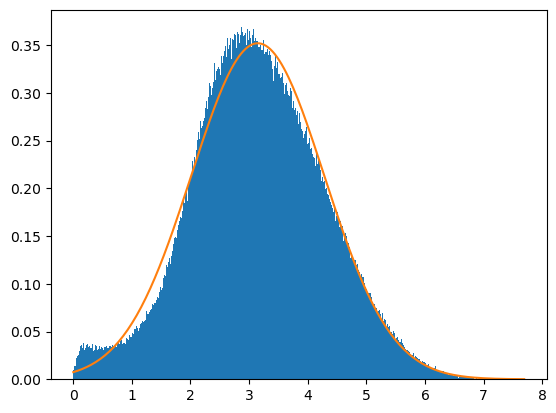

In [7]:
speed_offpeak_weekday = subset_offpeak_weekday.select(pl.col('speed')).to_series().to_list()
# print(speed_peak_weekday)
data_l1_a = speed_offpeak_weekday
data_l1_mean_a = np.mean(data_l1_a)
data_l1_std_a = np.std(data_l1_a)
print(data_l1_mean_a)
print(data_l1_std_a**2)

plt.hist(data_l1_a, bins=500, density=True)
xs_a = np.linspace(min(data_l1_a), max(data_l1_a), 200)
plt.plot(xs_a, norm.pdf(xs_a, loc=data_l1_mean_a, scale=data_l1_std_a))


Final Bin values: 500


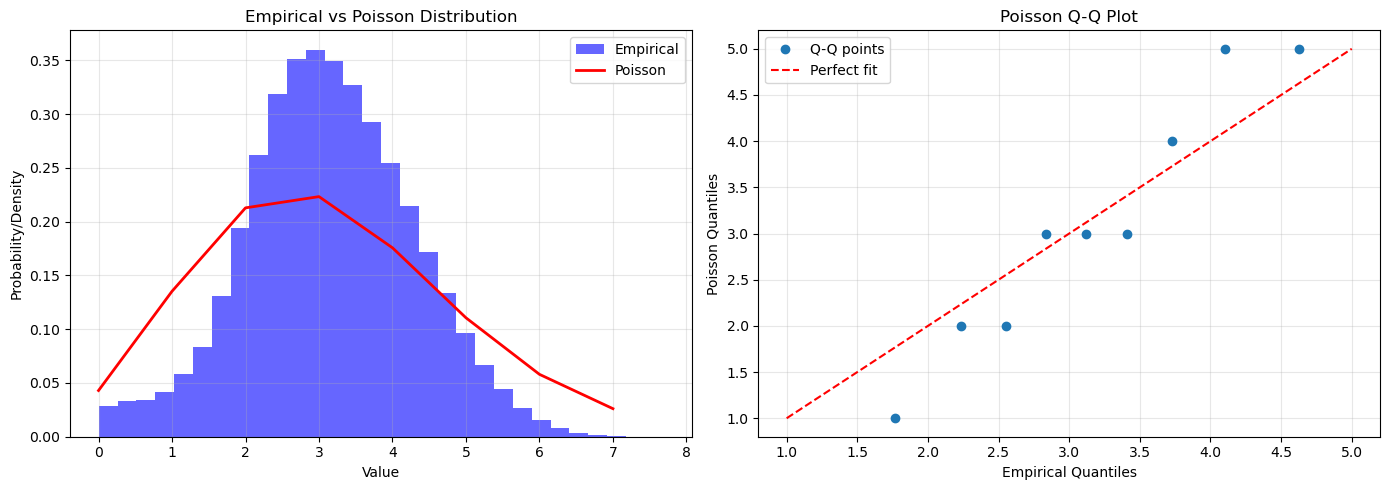

{'chi_score': np.float64(39297564.003732525), 'dispersion': np.float64(0.4079527327865518), 'emp_quantile': array([1.76355255, 2.23192485, 2.55385663, 2.83862034, 3.11673145,
       3.40670732, 3.72519012, 4.10540961, 4.62666392]), 'poisson_quantile': [np.float64(1.0), np.float64(2.0), np.float64(2.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(5.0)], 'p_value': np.float64(0.0)}


In [8]:
poi_dict_a = poisson_check(np.array(data_l1_a),bin_n = 500)
print(poi_dict_a)

Final Bin values: 500


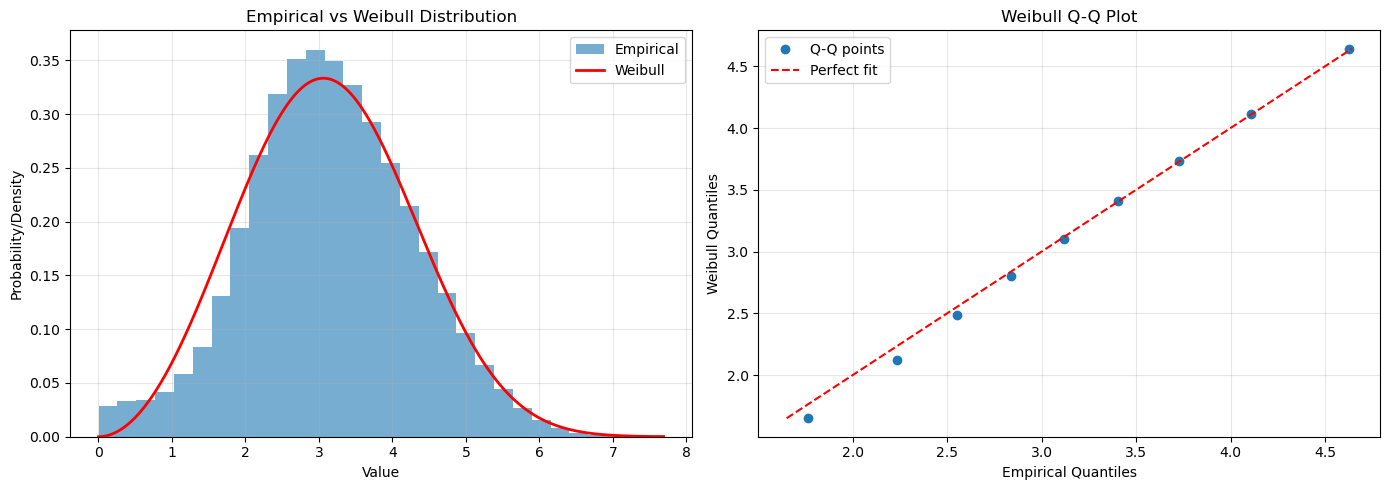

{'shape': np.float64(2.9833686891735196), 'loc': 0.0, 'scale': np.float64(3.50922393248459), 'weibull_mean': np.float64(3.1329022498682395), 'chi_score': np.float64(293911.54184043786), 'chi_p_value': np.float64(0.0), 'ks_stat': np.float64(0.02874843307333158), 'ks_p_value': np.float64(0.0), 'dispersion': np.float64(0.4079527327865518), 'emp_quantile': array([1.76355255, 2.23192485, 2.55385663, 2.83862034, 3.11673145,
       3.40670732, 3.72519012, 4.10540961, 4.62666392]), 'weibull_quantile': array([1.65052064, 2.12257015, 2.48391447, 2.80173171, 3.10353838,
       3.40788525, 3.73450558, 4.11610589, 4.64111921])}


In [9]:
wb_dict_a = weibull_check(np.array(data_l1_a),bin_n = 500)
print(wb_dict_a)

In [11]:
final_speed['weekday_off_peak'] = wb_dict_a['weibull_mean']
print(wb_dict_a['weibull_mean'])

3.1329022498682395


## Weekend ; Off-Peak hours

3.113676873490758
1.2834558254809485


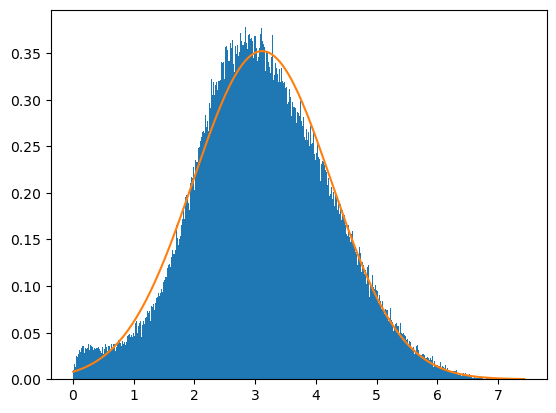

In [12]:
speed_offpeak_weekend = subset_offpeak_weekend.select(pl.col('speed')).to_series().to_list()
data_l1_b = speed_offpeak_weekend
data_l1_mean_b = np.mean(data_l1_b)
data_l1_std_b = np.std(data_l1_b)
print(data_l1_mean_b)
print(data_l1_std_b**2)

plt.hist(data_l1_b, bins=500, density=True)
xs_b = np.linspace(min(data_l1_b), max(data_l1_b), 200)
plt.plot(xs_b, norm.pdf(xs_b, loc=data_l1_mean_b, scale=data_l1_std_b))


Final Bin values: 500


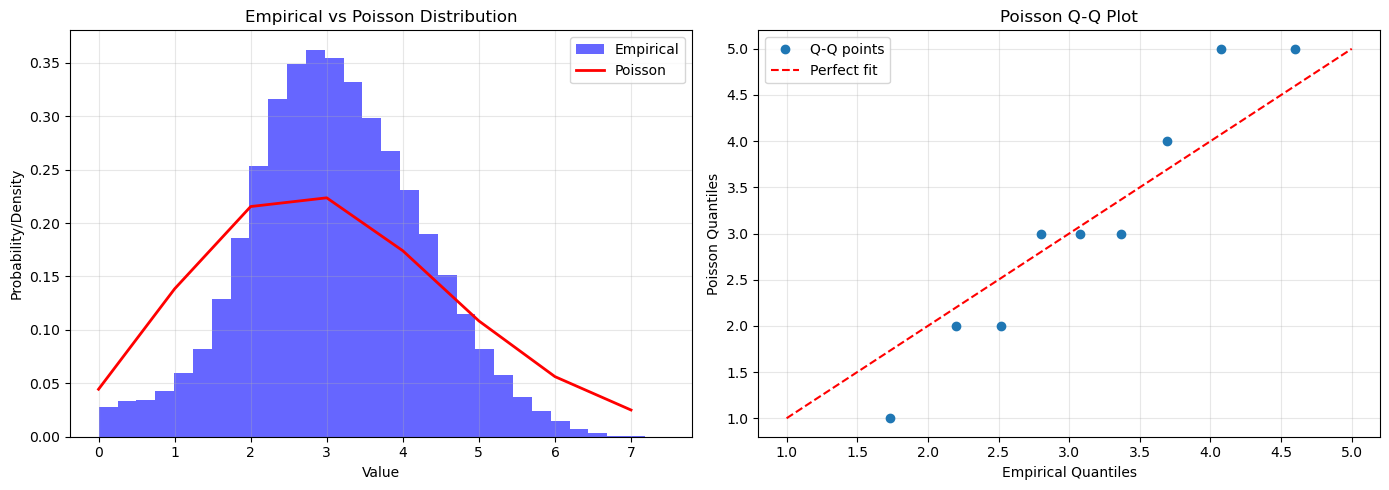

{'chi_score': np.float64(13742059.996328648), 'dispersion': np.float64(0.41220132315588115), 'emp_quantile': array([1.72898364, 2.19580472, 2.51420854, 2.79806828, 3.07539296,
       3.36456049, 3.69034618, 4.0729968 , 4.59795346]), 'poisson_quantile': [np.float64(1.0), np.float64(2.0), np.float64(2.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(5.0)], 'p_value': np.float64(0.0)}


In [13]:
poi_dict_b = poisson_check(np.array(data_l1_b),bin_n = 500)
print(poi_dict_b)

Final Bin values: 500


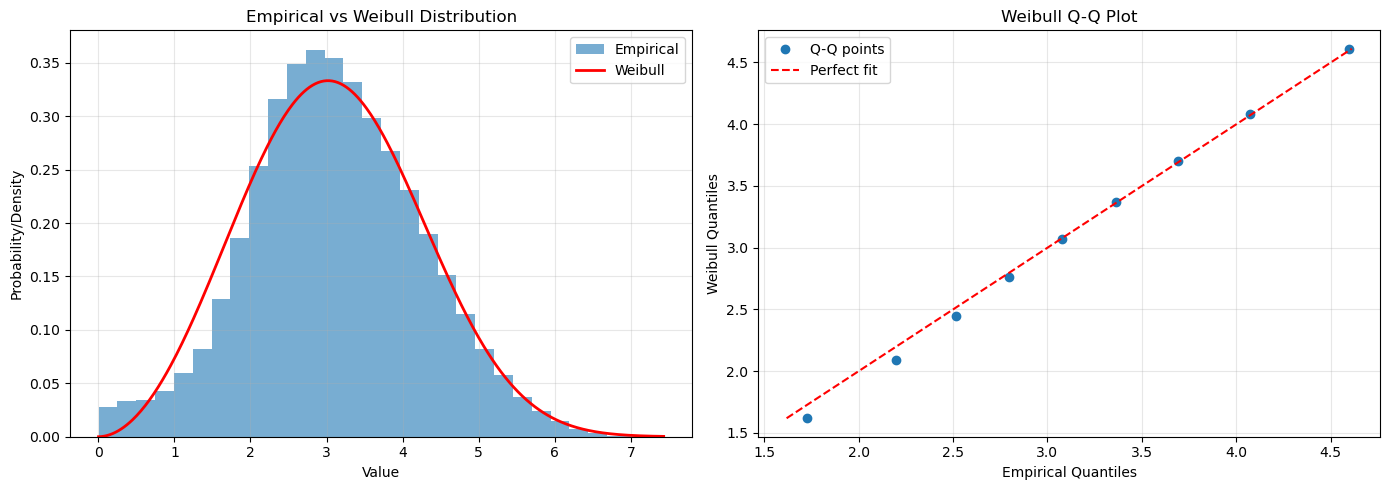

{'shape': np.float64(2.9473176907206637), 'loc': 0.0, 'scale': np.float64(3.4741710525873963), 'weibull_mean': np.float64(3.0999841048199737), 'chi_score': np.float64(82026.61574798024), 'chi_p_value': np.float64(0.0), 'ks_stat': np.float64(0.02867905631790771), 'ks_p_value': np.float64(7.932549201924841e-156), 'dispersion': np.float64(0.41220132315588115), 'emp_quantile': array([1.72898364, 2.19580472, 2.51420854, 2.79806828, 3.07539296,
       3.36456049, 3.69034618, 4.0729968 , 4.59795346]), 'weibull_quantile': array([1.61902688, 2.08848503, 2.44873096, 2.76611721, 3.06792417,
       3.37263556, 3.7000173 , 4.08294958, 4.61049888])}


In [14]:
wb_dict_b = weibull_check(np.array(data_l1_b),bin_n = 500)
print(wb_dict_b)

In [25]:
final_speed['weekend_off_peak'] = wb_dict_b['weibull_mean']
print(wb_dict_b['weibull_mean'])

3.0999841048199737


## Weekday ; Peak hours

3.143786961671963
1.0672464429661803


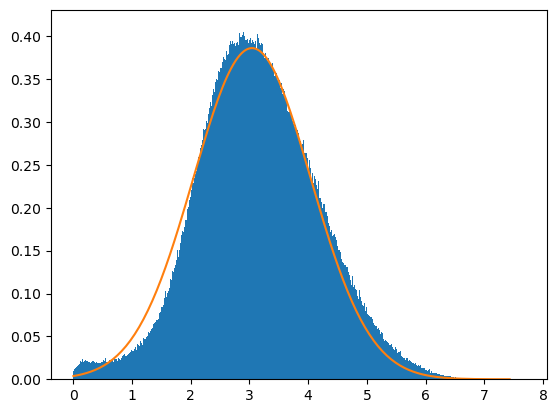

In [16]:
speed_peak_weekday =subset_peak_weekday.select(pl.col('speed')).to_series().to_list()
data_l1_c = speed_peak_weekday
data_l1_mean_c = np.mean(data_l1_c)
data_l1_std_c = np.std(data_l1_c)
print(data_l1_mean_c)
print(data_l1_std_c**2)

plt.hist(data_l1_c, bins=500, density=True)
xs_c = np.linspace(min(data_l1_c), max(data_l1_c), 200)
plt.plot(xs_b, norm.pdf(xs_c, loc=data_l1_mean_c, scale=data_l1_std_c))


Final Bin values: 500


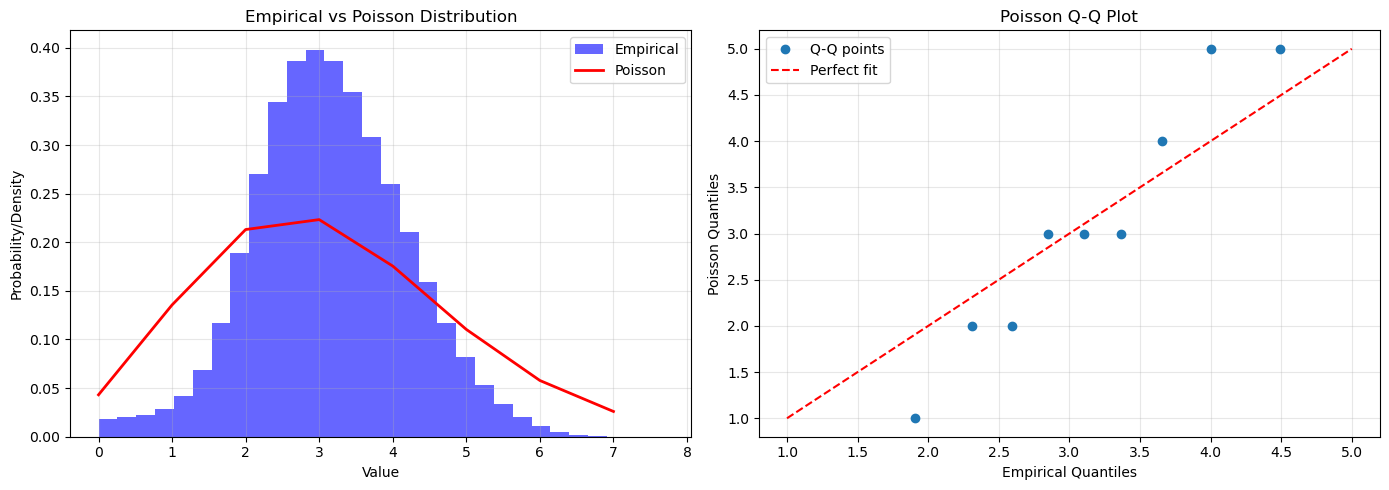

{'chi_score': np.float64(51353827.918131754), 'dispersion': np.float64(0.33947838393628255), 'emp_quantile': array([1.90740463, 2.30907604, 2.59579153, 2.85188216, 3.10327489,
       3.36439871, 3.65304181, 4.0031364 , 4.49156147]), 'poisson_quantile': [np.float64(1.0), np.float64(2.0), np.float64(2.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(5.0)], 'p_value': np.float64(0.0)}


In [17]:
poi_dict_c = poisson_check(np.array(data_l1_c),bin_n = 500)
print(poi_dict_c)

Final Bin values: 500


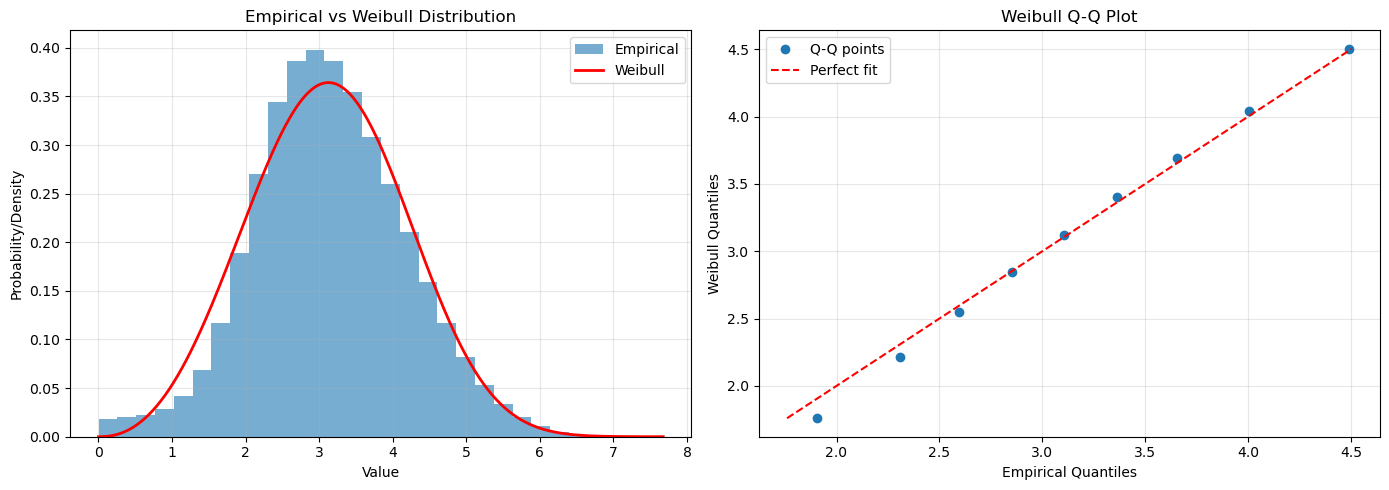

{'shape': np.float64(3.2826449080682027), 'loc': 0.0, 'scale': np.float64(3.4925193958626606), 'weibull_mean': np.float64(3.1320161870625918), 'chi_score': np.float64(1118087.530326173), 'chi_p_value': np.float64(0.0), 'ks_stat': np.float64(0.030059181221637227), 'ks_p_value': np.float64(0.0), 'dispersion': np.float64(0.33947838393628255), 'emp_quantile': array([1.90740463, 2.30907604, 2.59579153, 2.85188216, 3.10327489,
       3.36439871, 3.65304181, 4.0031364 , 4.49156147]), 'weibull_quantile': array([1.75960361, 2.21154872, 2.55121203, 2.84622501, 3.12355462,
       3.40073615, 3.69570484, 4.03736945, 4.5027876 ])}


In [18]:
wb_dict_c = weibull_check(np.array(data_l1_c),bin_n = 500)
print(wb_dict_c)

In [26]:
final_speed['weekday_peak'] = wb_dict_c['weibull_mean']
print(wb_dict_c['weibull_mean'])

3.1320161870625918


## Weekend ; Peak hours

3.113676873490758
1.2834558254809485


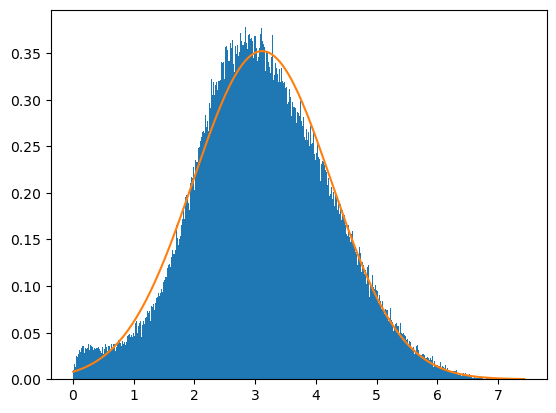

In [20]:
speed_peak_weekend = subset_peak_weekend.select(pl.col('speed')).to_series().to_list()
data_l1_d = speed_offpeak_weekend
data_l1_mean_d = np.mean(data_l1_d)
data_l1_std_d = np.std(data_l1_d)
print(data_l1_mean_d)
print(data_l1_std_d**2)

plt.hist(data_l1_d, bins=500, density=True)
xs_d = np.linspace(min(data_l1_d), max(data_l1_d), 200)
plt.plot(xs_d, norm.pdf(xs_d, loc=data_l1_mean_d, scale=data_l1_std_d))

Final Bin values: 500


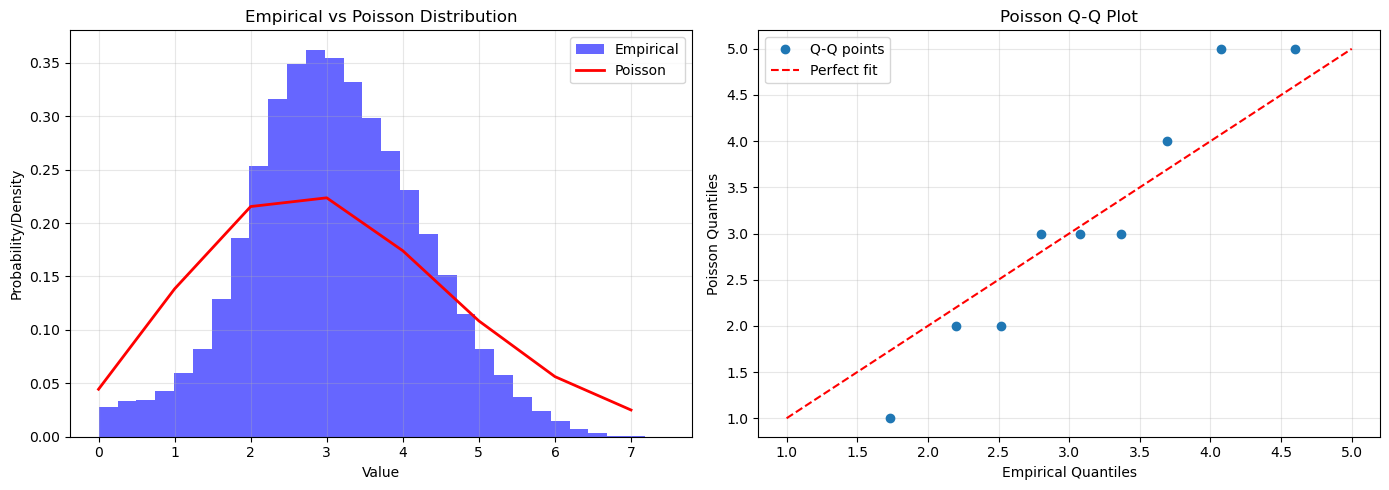

{'chi_score': np.float64(13742059.996328648), 'dispersion': np.float64(0.41220132315588115), 'emp_quantile': array([1.72898364, 2.19580472, 2.51420854, 2.79806828, 3.07539296,
       3.36456049, 3.69034618, 4.0729968 , 4.59795346]), 'poisson_quantile': [np.float64(1.0), np.float64(2.0), np.float64(2.0), np.float64(3.0), np.float64(3.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(5.0)], 'p_value': np.float64(0.0)}


In [21]:
poi_dict_d = poisson_check(np.array(data_l1_d),bin_n = 500)
print(poi_dict_d)

Final Bin values: 500


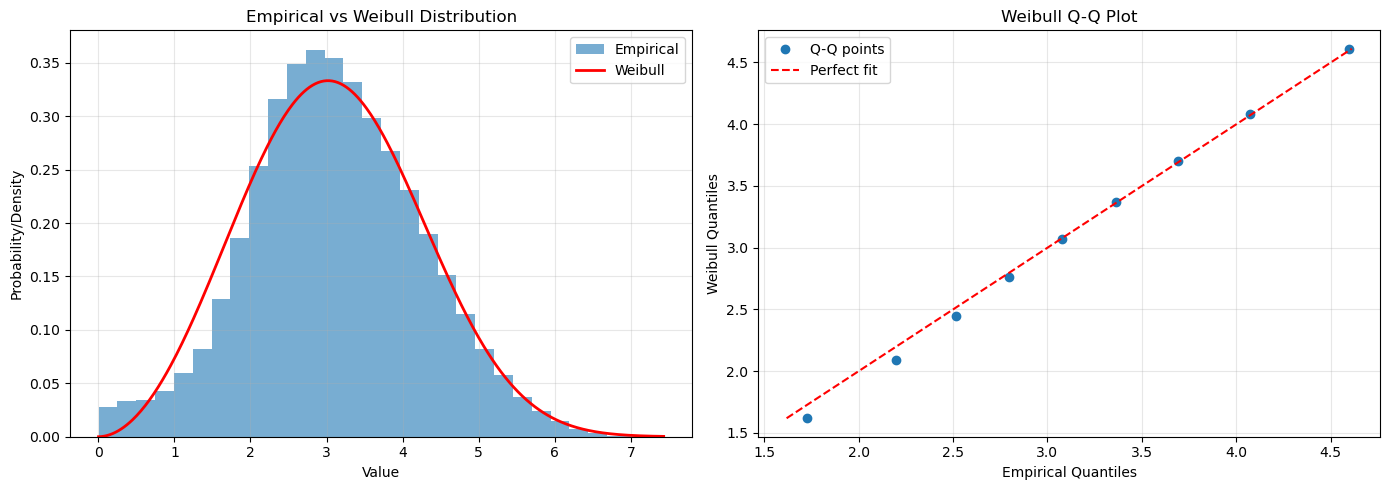

{'shape': np.float64(2.9473176907206637), 'loc': 0.0, 'scale': np.float64(3.4741710525873963), 'weibull_mean': np.float64(3.0999841048199737), 'chi_score': np.float64(82026.61574798024), 'chi_p_value': np.float64(0.0), 'ks_stat': np.float64(0.02867905631790771), 'ks_p_value': np.float64(7.932549201924841e-156), 'dispersion': np.float64(0.41220132315588115), 'emp_quantile': array([1.72898364, 2.19580472, 2.51420854, 2.79806828, 3.07539296,
       3.36456049, 3.69034618, 4.0729968 , 4.59795346]), 'weibull_quantile': array([1.61902688, 2.08848503, 2.44873096, 2.76611721, 3.06792417,
       3.37263556, 3.7000173 , 4.08294958, 4.61049888])}


In [22]:
wb_dict_d = weibull_check(np.array(data_l1_d),bin_n = 500)
print(wb_dict_d)

In [27]:
final_speed['weekend_peak'] = wb_dict_d['weibull_mean']
print(wb_dict_d['weibull_mean'])

3.0999841048199737


In [46]:
print('X'*80)
print('\nFinal expected speed values')
print('X'*80)
print('\n{}'.format(final_speed))

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

Final expected speed values
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

{'weekday_off_peak': np.float64(3.1329022498682395), 'weekend_off_peak': np.float64(3.0999841048199737), 'weekday_peak': np.float64(3.1320161870625918), 'weekend_peak': np.float64(3.0999841048199737)}


# Rideable type

In [29]:
d1 = subset_peak_weekday.group_by('rideable_type').agg(pl.col('speed'))
d2 = subset_peak_weekend.group_by('rideable_type').agg(pl.col('speed'))
d3 = subset_offpeak_weekend.group_by('rideable_type').agg(pl.col('speed'))
d4 = subset_offpeak_weekday.group_by('rideable_type').agg(pl.col('speed'))
print(d1)

shape: (2, 2)
┌───────────────┬─────────────────────────────────┐
│ rideable_type ┆ speed                           │
│ ---           ┆ ---                             │
│ str           ┆ list[f64]                       │
╞═══════════════╪═════════════════════════════════╡
│ classic_bike  ┆ [3.09446, 2.063323, … 2.947105… │
│ electric_bike ┆ [2.941534, 4.03045, … 4.324311… │
└───────────────┴─────────────────────────────────┘


In [43]:
electric_speeds = (
    d4
    .filter(pl.col("rideable_type") == "electric_bike")
    .select("speed")
    .item()           # extract the single list from the column
).to_list()

classic_speeds = (
    d4
    .filter(pl.col("rideable_type") == "classic_bike")
    .select("speed")
    .item()
).to_list()

print(len(electric_speeds))

418923


Final Bin values: 500


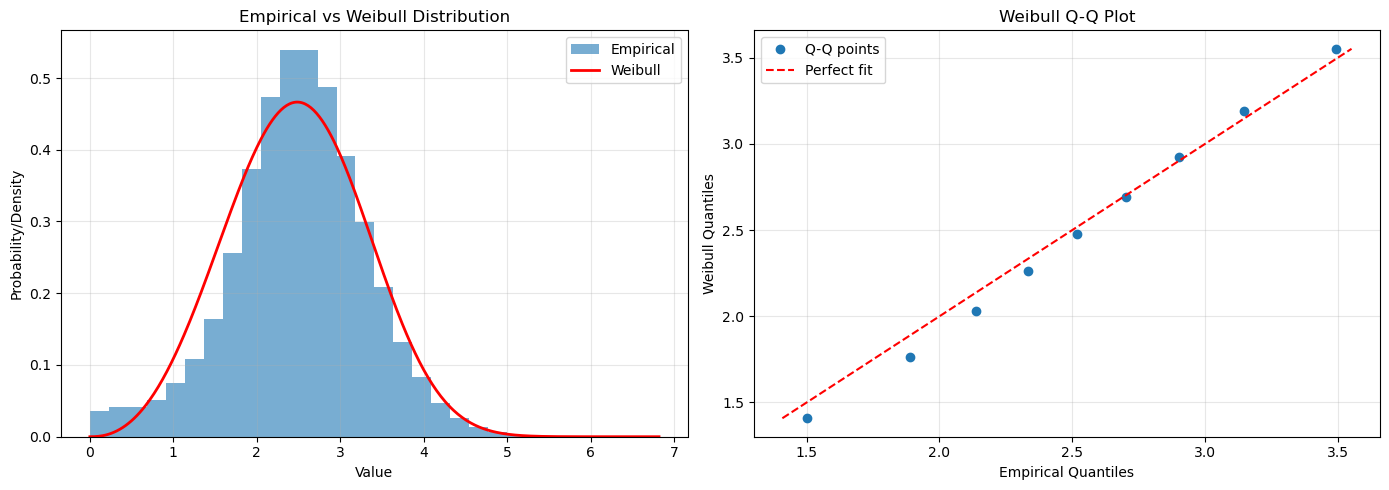

{'shape': np.float64(3.3346292292083146), 'loc': 0.0, 'scale': np.float64(2.765750601730764), 'weibull_mean': np.float64(2.4822290993904823), 'chi_score': np.float64(1111288.4915504826), 'chi_p_value': np.float64(0.0), 'ks_stat': np.float64(0.046863592347160477), 'ks_p_value': np.float64(0.0), 'dispersion': np.float64(0.2639082918641825), 'emp_quantile': array([1.49934684, 1.89072038, 2.13571865, 2.33392927, 2.51872285,
       2.70328355, 2.90309159, 3.14503826, 3.49171504]), 'weibull_quantile': array([1.40841397, 1.76386062, 2.0302382 , 2.26114716, 2.47787396,
       2.6941851 , 2.92407576, 3.19000371, 3.5516936 ])}


In [44]:
wb_dict_classic = weibull_check(np.array(classic_speeds),bin_n = 500)
print(wb_dict_classic)

Final Bin values: 500


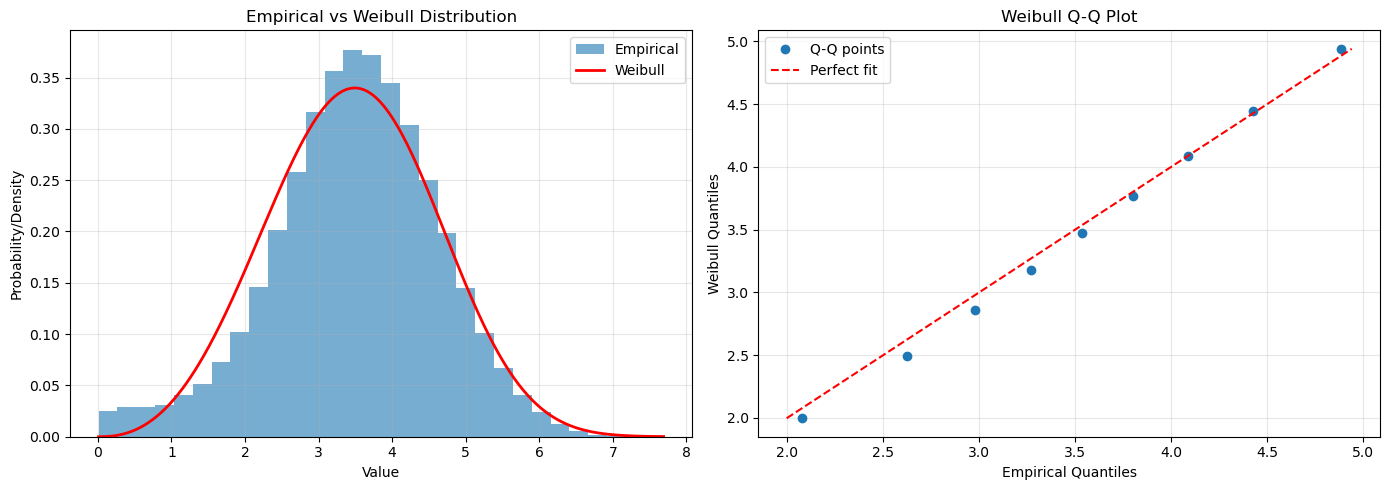

{'shape': np.float64(3.4045645425030315), 'loc': 0.0, 'scale': np.float64(3.867016637170767), 'weibull_mean': np.float64(3.474299427269166), 'chi_score': np.float64(472065.2100522897), 'chi_p_value': np.float64(0.0), 'ks_stat': np.float64(0.03817863785044079), 'ks_p_value': np.float64(0.0), 'dispersion': np.float64(0.3643613036331767), 'emp_quantile': array([2.0750503 , 2.62528342, 2.97979042, 3.26928754, 3.53630037,
       3.80254144, 4.08976373, 4.42466202, 4.88580377]), 'weibull_quantile': array([1.99670426, 2.48908696, 2.85672255, 3.17459934, 3.47234418,
       3.76898435, 4.08371136, 4.44714286, 4.94045827])}


In [45]:
wb_dict_elec = weibull_check(np.array(electric_speeds),bin_n = 500)
print(wb_dict_elec)

In [47]:
rideable_speeds_c = {
    "peak_weekday":2.5493,
    "peak_weekend":2.4847,
    "offpeak_weekend":2.4567,
    "offpeak_weekday":2.4822
}
rideable_speeds_e = {
    "peak_weekday":3.4647,
    "peak_weekend":3.4719,
    "offpeak_weekend":3.4496,
    "offpeak_weekday":3.4742
}

In [48]:
print('X'*80)
print('\nFinal expected speed values - Classic Bike')
print('X'*80)
print('\n{}'.format(rideable_speeds_c))

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

Final expected speed values - Classic Bike
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

{'peak_weekday': 2.5493, 'peak_weekend': 2.4847, 'offpeak_weekend': 2.4567, 'offpeak_weekday': 2.4822}


In [49]:
print('X'*80)
print('\nFinal expected speed values - Electric Bike')
print('X'*80)
print('\n{}'.format(rideable_speeds_e))

XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

Final expected speed values - Electric Bike
XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

{'peak_weekday': 3.4647, 'peak_weekend': 3.4719, 'offpeak_weekend': 3.4496, 'offpeak_weekday': 3.4742}
